# **Análisis de Regresión Logística** 📈

En esta sesión, aprenderás a realizar un análisis de regresión logística utilizando datos de matrícula de educación superior de los años 2021 y 2022. La regresión logística es una técnica estadística utilizada para modelar la probabilidad de ocurrencia de un evento binario, como la deserción de estudiantes, en función de una o más variables independientes. Exploraremos cómo preparar los datos, ajustar el modelo, evaluar los supuestos, interpretar los resultados y visualizar las relaciones entre las variables.

Comencemos estableciendo el directorio de trabajo.

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Instalar y Cargar Paquetes**

Instalemos y carguemos los paquetes que utilizaremos en esta sesión

In [11]:
!pip install pandas matplotlib seaborn statsmodels scikit-learn

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import logit
from sklearn.metrics import classification_report, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy import stats

## **Importar Datos**

Importamos los datos de matrícula de educación superior para los años 2021 y 2022. Luego, seleccionamos la cohorte de estudiantes que ingresaron en 2021 para estudiar la deserción en su primer año.

In [20]:
mat2021 = pd.read_csv("/content/drive/My Drive/Teaching/Metodología Cuantitativa II 2024/Sesión 3/20230802_Matrícula_Ed_Superior_2021_PUBL_MRUN.csv", sep=";")
mat2022 = pd.read_csv("/content/drive/My Drive/Teaching/Metodología Cuantitativa II 2024/Sesión 3/20230802_Matrícula_Ed_Superior_2022_PUBL_MRUN.csv", sep=";")

## **Selección y manipulación**

Parte importante del análisis de datos es la creación, transformación, limpieza y recodificación de datos para los propósitos que se busca. Aprendamos un poco acerca de aquellos con este trozo de código donde seleccionamos casos según cohorte y crearemos una nueva variable dependiente dicotómica que nos señalará deserción universitaria en base a estos dos conjuntos de datos de `mat2021` y `mat2022`.

In [21]:
# Selección de casos: Cohorte que ingresó en 2021
mat2021_1anio = mat2021[mat2021['anio_ing_carr_ori'] == 2021]
mat2022_2anio = mat2022[mat2022['anio_ing_carr_ori'] == 2021]

# Generación de variable dependiente: Indicador de Deserción
mat2021_1anio['deserta'] = np.where(mat2021_1anio['mrun'].isin(mat2022_2anio['mrun']), 0, 1)

# Seleccionamos solo a estudiantes de pregrado
mat2021_1anio = mat2021_1anio[mat2021_1anio['nivel_global'] == "Pregrado"]

# Exploración de los datos
print(mat2021_1anio.head())
print(mat2021_1anio.shape)
print(mat2021_1anio.info())

# Recodificación de la variable género
mat2021_1anio['female'] = np.where(mat2021_1anio['gen_alu'] == 2, 1, 0)

# Cálculo de la edad al ingreso en la educación superior
from datetime import datetime
mat2021_1anio['fec_nac_alu'] = mat2021_1anio['fec_nac_alu'].astype(str)
mat2021_1anio['anio_nac'] = mat2021_1anio['fec_nac_alu'].str[:4].astype(int)
mat2021_1anio['anio_ing_carr_ori'] = mat2021_1anio['anio_ing_carr_ori'].astype(int)
mat2021_1anio['edad_alu'] = mat2021_1anio['anio_ing_carr_ori'] - mat2021_1anio['anio_nac']

# Filtramos datos erróneos de edad
print(mat2021_1anio['edad_alu'].describe())
mat2021_1anio = mat2021_1anio[mat2021_1anio['edad_alu'] != 121]
print(mat2021_1anio['edad_alu'].describe())

# Filtrar para eliminar NA's presentes en predictores para conformar la muestra analítica de interés
mat2021_1anio = mat2021_1anio.dropna(subset=['female', 'edad_alu', 'dur_total_carr', 'valor_arancel'])

# Removamos los data frames que no utilizaremos para liberar espacio de memoria RAM
del mat2021, mat2022, mat2022_2anio

<ipython-input-21-d4cfe2d58da1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mat2021_1anio['deserta'] = np.where(mat2021_1anio['mrun'].isin(mat2022_2anio['mrun']), 0, 1)


    cat_periodo       id     codigo_unico   mrun  gen_alu  fec_nac_alu  \
3          2021   794616    I111S22C8J1V1   98.0        2       200212   
4          2021   755594  I111S12C420J1V1   99.0        1       200301   
6          2021  1131128  I430S10C326J1V1  137.0        1       200104   
7          2021   754806  I111S12C413J1V1  140.0        1       200106   
14         2021    71451   I13S10C384J2V2  341.0        2       198803   

      rango_edad  anio_ing_carr_ori  sem_ing_carr_ori  anio_ing_carr_act  ...  \
3   15 a 19 años               2021                 1               2021  ...   
4   15 a 19 años               2021                 1               2021  ...   
6   20 a 24 años               2021                 1               2021  ...   
7   20 a 24 años               2021                 1               2021  ...   
14  30 a 34 años               2021                 1               2021  ...   

                                   cine_f_13_area  \
3              

## **Visualización de la Variable Dependiente**
Visualizamos la distribución de la variable dependiente `deserta` utilizando un gráfico de barras.

<ipython-input-22-061729e740fb>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='deserta', data=mat2021_1anio, palette=['#87ceeb', '#ffd700'])


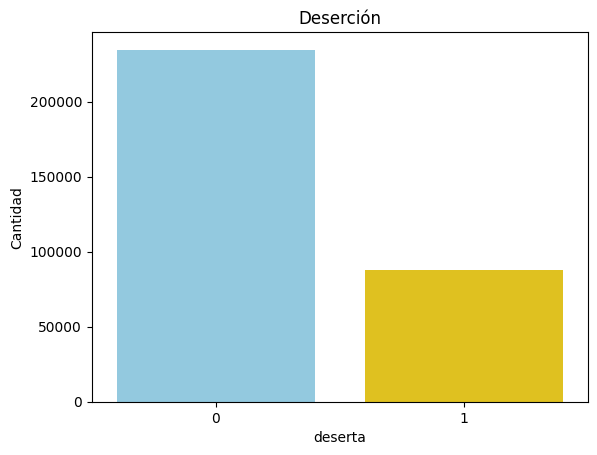

In [22]:
sns.countplot(x='deserta', data=mat2021_1anio, palette=['#87ceeb', '#ffd700'])
plt.title("Deserción")
plt.ylabel("Cantidad")
plt.show()

## **Análisis de Regresión Logística**
Ajustamos un modelo de regresión logística para predecir la deserción (`deserta`) en función de las variables `female` (género) y `edad_alu` (edad al ingreso).

In [23]:
# Ajustamos un modelo de regresión logística para predecir la deserción
X = mat2021_1anio[['female', 'edad_alu']]
y = mat2021_1anio['deserta']

# Agregar constante al modelo
X = sm.add_constant(X)

# Ajustar el modelo de regresión logística
model = sm.Logit(y, X).fit()

# Resumen del modelo
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.571385
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                deserta   No. Observations:               322341
Model:                          Logit   Df Residuals:                   322338
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 Aug 2024   Pseudo R-squ.:                 0.02452
Time:                        23:57:47   Log-Likelihood:            -1.8418e+05
converged:                       True   LL-Null:                   -1.8881e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9046      0.013   -143.079      0.000      -1.931      -1.879
female        -0.2973      0.

### **Evaluación de los Supuestos de la Regresión Logística**
Es importante verificar que los supuestos de la regresión logística se cumplen para garantizar la validez de las estimaciones del modelo.

-    **Variable dependiente categórica**: La variable que estamos tratando de predecir (deserta) es binaria, lo que cumple con el primer supuesto.
-    **Independencia de las observaciones**: Este supuesto no se evalúa estadísticamente, pero es importante asegurarse de que cada observación (estudiante) es independiente de las demás.
-    **Supuesto de Linealidad**: implica que la relación entre el logit de la variable dependiente y cada variable independiente es lineal. Verificamos este supuesto usando el Test Box-Tidwell. Si el resultado del test es no significativo, no se rechaza la hipótesis nula de linealidad, lo que indica que el supuesto de linealidad se cumple.

In [25]:
# Supuesto de Linealidad
log_odds = model.predict()
mat2021_1anio['log_odds'] = log_odds

# Test de Box-Tidwell
mat2021_1anio['edad_alu_log'] = mat2021_1anio['edad_alu'] * np.log(mat2021_1anio['edad_alu'])
box_tidwell_model = sm.Logit(y, sm.add_constant(mat2021_1anio[['edad_alu', 'edad_alu_log']])).fit()
print(box_tidwell_model.summary())

Optimization terminated successfully.
         Current function value: 0.567471
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                deserta   No. Observations:               322341
Model:                          Logit   Df Residuals:                   322338
Method:                           MLE   Df Model:                            2
Date:                Tue, 20 Aug 2024   Pseudo R-squ.:                 0.03120
Time:                        23:58:15   Log-Likelihood:            -1.8292e+05
converged:                       True   LL-Null:                   -1.8881e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.6257      0.093    -81.935      0.000      -7.808      -7.443
edad_alu         0.9001

-    **Supuesto de Ausencia de Multicolinealidad**: La multicolinealidad ocurre cuando las variables independientes están altamente correlacionadas entre sí. Evaluamos este supuesto utilizando la matriz de correlación y el Factor de Inflación de la Varianza (VIF). Si los valores de VIF son menores a 5, se considera que no hay un problema significativo de multicolinealidad. Si las correlacione son mayores a *r* > .08, entonces también es un indicador de multicolinealidad.

In [26]:
X['valor_arancel'] = mat2021_1anio['valor_arancel'].astype(float)
X['dur_total_carr'] = mat2021_1anio['dur_total_carr'].astype(float)
model_mult = sm.Logit(y, X).fit()

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
print(vif)

Optimization terminated successfully.
         Current function value: 0.555859
         Iterations 6
   VIF Factor        features
0   29.287643           const
1    1.001549          female
2    1.178768        edad_alu
3    1.945506   valor_arancel
4    1.883022  dur_total_carr


Los resultados de estos análisis sugieren que se cumple el supuesto de ausencia de multicolinealidad entre las variables independientes del modelo.

### **Resultados de la Regresión Logística**
Interpretamos los resultados del modelo ajustado `m3`, evaluando la significancia de los coeficientes, direccionalidad y tamaño de los coeficientes y calculando las probabilidades estimadas. También, en regresión logística es posible obtener el pseudo R2 que nos muestra la proporción de la varianza explicada de nuestra variable dependiente por el modelo.

In [27]:
# Ajustamos el modelo de regresión logística con más variables independientes
X = mat2021_1anio[['female', 'edad_alu', 'dur_total_carr', 'valor_arancel']]
y = mat2021_1anio['deserta']

# Añadimos una constante al modelo (intercepto)
X = sm.add_constant(X)

# Ajustamos el modelo logístico
model_mult = sm.Logit(y, X).fit()

# Resumen del modelo
print(model_mult.summary())

Optimization terminated successfully.
         Current function value: 0.555859
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                deserta   No. Observations:               322341
Model:                          Logit   Df Residuals:                   322336
Method:                           MLE   Df Model:                            4
Date:                Tue, 20 Aug 2024   Pseudo R-squ.:                 0.05102
Time:                        23:58:31   Log-Likelihood:            -1.7918e+05
converged:                       True   LL-Null:                   -1.8881e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3097      0.021    -14.646      0.000      -0.351      -0.268
female           

#### **Cálculo del McFadden's R²**
También, en regresión logística es posible obtener el McFadden's R²  que nos muestra la proporción de la varianza explicada de nuestra variable dependiente por el modelo. El Pseudo R² de McFadden se interpreta de manera similar al R² en la regresión lineal, aunque los valores son generalmente más bajos.

In [28]:
ll_null = model_mult.llnull  # log-likelihood del modelo nulo
ll_model = model_mult.llf  # log-likelihood del modelo ajustado
pseudo_r2_mcfadden = 1 - (ll_model / ll_null)
print("Pseudo R² (McFadden):", pseudo_r2_mcfadden)

Pseudo R² (McFadden): 0.05102261321620172


#### **Coeficientes estimados: log-odds y odd ratios**

Los coeficientes de regresión logística son el logaritmo natural de los odds (log-odds) de que ocurra el evento de la variable dependiente, que en este caso es desertar o no. La forma más intuitiva de interpretarlos es elevar al cuadrado los exponentes para obtenerlos en razones de odds (odd-ratio), los cuales pueden ser interpretados como la probabilidad de que un evento ocurra respecto a que no ocurra. Calculemos aquello en el siguiente código.

In [29]:
# Calcular los odds ratios y sus intervalos de confianza
odds_ratios = np.exp(model_mult.params)
conf = np.exp(model_mult.conf_int())
print("Odds Ratios:\n", odds_ratios)
print("Confianza Interval:\n", conf)

Odds Ratios:
 const             0.733697
female            0.740022
edad_alu          1.027034
dur_total_carr    0.851572
valor_arancel     1.000000
dtype: float64
Confianza Interval:
                        0         1
const           0.703914  0.764741
female          0.728260  0.751973
edad_alu        1.025987  1.028082
dur_total_carr  0.848000  0.855158
valor_arancel   1.000000  1.000000


**Interpretación**: se puede señalar que, por cada unidad que aumenta la edad del estudiante `edad_alu`, entonces la probabilidad de desertar en primer año es del 3%.

### **Comparación respecto al modelo nulo**
Al estimar un chi-cuadrado del modelo (`m3`), podemos evaluar si es significativamente mejor que el modelo nulo o vacío (i.e. que contiene solo el intercepto y ningún predictor).

In [30]:
modelChi = model_mult.llnull - model_mult.llf
chidf = model_mult.df_model
chisq_prob = 1 - stats.chi2.cdf(modelChi, chidf)
print("Chi-square:", modelChi)
print("p-value:", chisq_prob)

Chi-square: -9633.561328509008
p-value: 1.0


#### **Probabilidades estimadas**
Por ejemplo, en el siguiente código podemos obtener la probabilidad de que una mujer de 19 años, en un programa de 5 semestres de duración y con un arancel de $2.510.000 deserte es de 27%.

In [31]:
mat2021_1anio['Probabilidades_estimadas'] = model_mult.predict(X)
print(mat2021_1anio[['deserta', 'female', 'edad_alu', 'dur_total_carr', 'valor_arancel', 'Probabilidades_estimadas']].head(10))

    deserta  female  edad_alu  dur_total_carr  valor_arancel  \
3         0       1        19               5      2510000.0   
4         0       0        18               5      2240000.0   
6         1       0        20               4      2212000.0   
7         1       0        20               8      2430000.0   
14        1       1        33               2      2097000.0   
18        0       0        20              11      3869000.0   
20        0       0        20               4      2064000.0   
21        0       0        20              10      3325000.0   
23        1       1        23               8      2230000.0   
24        0       1        19               8      1900000.0   

    Probabilidades_estimadas  
3                   0.272719  
4                   0.332134  
6                   0.381377  
7                   0.243647  
14                  0.471707  
18                  0.160165  
20                  0.382401  
21                  0.185371  
23              

#### **Bondad de clasificación**

La bondad de clasificación es un análisis para evaluar la capacidad predictiva del modelo a nivel de los estudiantes, indicándonos la proporción de estudiantes que han sido clasificados correctamente por el modelo. Como vemos en el siguiente código, la precisión de la predicción es del 73%, lo que indica que nuestro modelo logra una mejora razonable de las predicciones.

In [32]:
probabilities = model_mult.predict(X)
predicted = np.where(probabilities > 0.5, 1, 0)
print("Precisión del modelo:", np.mean(predicted == y))

Precisión del modelo: 0.7278348084792192


### **Visualización**
Visualizamos los resultados del modelo de regresión logística ajustado, incluyendo la relación entre las variables independientes y la probabilidad de deserción.


Optimization terminated successfully.
         Current function value: 0.573508
         Iterations 5


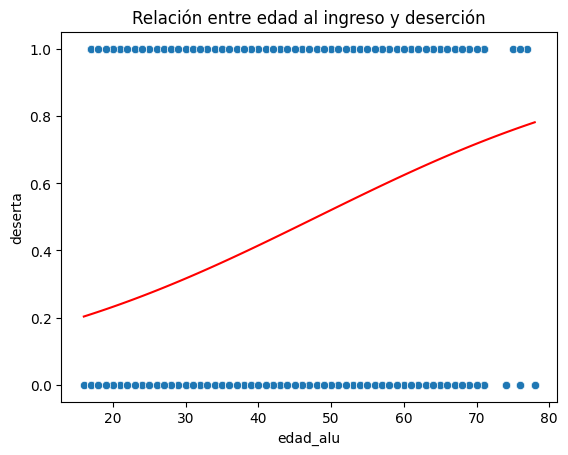

Optimization terminated successfully.
         Current function value: 0.562383
         Iterations 5


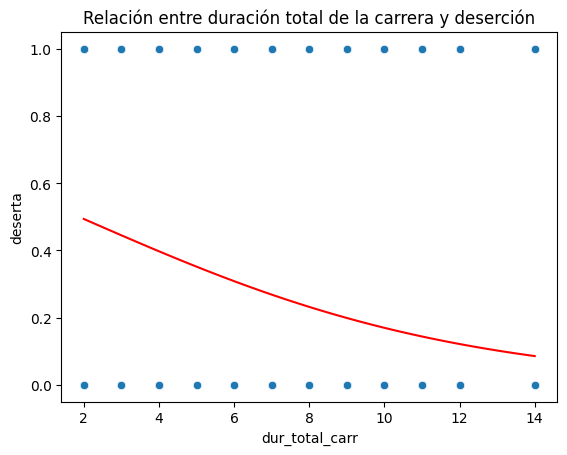

Optimization terminated successfully.
         Current function value: 0.572051
         Iterations 6


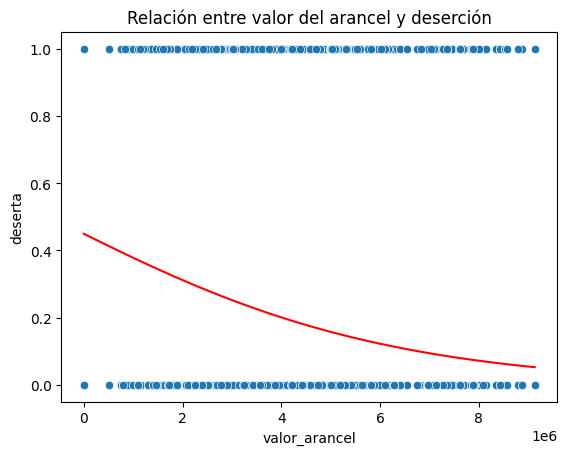

In [36]:
# Relación entre edad al ingreso y deserción
sns.scatterplot(x='edad_alu', y='deserta', data=mat2021_1anio)
plt.title('Relación entre edad al ingreso y deserción')
X = mat2021_1anio['edad_alu']
X = sm.add_constant(X)
logit_model = sm.Logit(mat2021_1anio['deserta'], X).fit()
x_vals = np.linspace(X['edad_alu'].min(), X['edad_alu'].max(), 100)
y_vals = logit_model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red')
plt.show()

# Relación entre duración total de la carrera y deserción
sns.scatterplot(x='dur_total_carr', y='deserta', data=mat2021_1anio)
plt.title('Relación entre duración total de la carrera y deserción')
X = mat2021_1anio['dur_total_carr']
X = sm.add_constant(X)
logit_model = sm.Logit(mat2021_1anio['deserta'], X).fit()
x_vals = np.linspace(X['dur_total_carr'].min(), X['dur_total_carr'].max(), 100)
y_vals = logit_model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red')
plt.show()

# Relación entre valor del arancel y deserción
sns.scatterplot(x='valor_arancel', y='deserta', data=mat2021_1anio)
plt.title('Relación entre valor del arancel y deserción')
X = mat2021_1anio['valor_arancel']
X = sm.add_constant(X)
logit_model = sm.Logit(mat2021_1anio['deserta'], X).fit()
x_vals = np.linspace(X['valor_arancel'].min(), X['valor_arancel'].max(), 100)
y_vals = logit_model.predict(sm.add_constant(x_vals))
plt.plot(x_vals, y_vals, color='red')
plt.show()

#### **Comparación de Modelos**
Similarmentem puedes comparar los modelos utilizando los estadísticos de ajuste, como el AIC (Criterio de Información de Akaike) o BIC (Criterio de Información Bayesiana). Un modelo con un valor de AIC o BIC más bajo se considera que ajusta mejor los datos.

In [37]:
print("AIC m2:", model.aic)
print("AIC m3:", model_mult.aic)
print("BIC m2:", model.bic)
print("BIC m3:", model_mult.bic)

AIC m2: 368367.5633705325
AIC m3: 358362.1610785302
BIC m2: 368399.6134663436
BIC m3: 358415.57790488214
